In [2]:
# 중고차 가격 예측

In [57]:
# 라이브러리 import
# pandas: csv 파일 처리에 유용
# matplotlib: 데이터 시각화에 이용
# sklearn: 머신러닝 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn import preprocessing

In [5]:
# data 파일 불러와서 구조 확인
dummy_data = pd.read_csv('./train-data.csv')
dummy_data.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [6]:
# data의 row, col 수를 알아보자
print('row 수: {}, col 수: {}'.format(dummy_data.shape[0], dummy_data.shape[1]))

row 수: 6019, col 수: 14


In [7]:
# 자동차의 모델, 연식, 킬로미터수, 연료타입 등을 활용하여 가격을 예측해보자!
# CH 3에서 언급했던 회귀모델을 이용할 것.

In [9]:
## 데이터 전처리

# NaN(결측치)를 확인하고 제거
# 결측치란? 누락된 데이터, 종류(패턴이 없는 무작위값, 패턴을 가진 값)
# 데이터가 수치 값이면 평균값을 넣어주는 등의 처리 
# 문자열이면 대체하기 어려워 해당 row 제거

# 일단 결측치를 제거해서 처리해보자
clean_data = dummy_data.copy(deep=True)
clean_data.dropna('index').shape

(823, 14)

In [10]:
# 6019개 -> 823개. 너무 많이 손실된다!
# 왜그런지 보니까 New_Price의 값에 NaN이 굉장히 많다.
# 그냥 New_Price 컬럼을 제거해버리자
# + unnamed:0 컬럼도 단순 인덱스 표시용이므로 제거하자
clean_data.drop(columns=['Unnamed: 0', 'New_Price'], inplace=True)
clean_data.dropna('index', inplace=True)
clean_data = clean_data.reset_index(drop=True)
clean_data.shape

(5975, 12)

In [12]:
# 우선 차의 모델명
# 차의 모델명: Name 컬럼
# 오버피팅을 초래할 수 있기 때문에 차종의 Hyundai Creta ...에서 Hyundai만 남김
names = list(clean_data.Name)
for i in range(len(names)):
    names[i] = names[i].split(' ', 1)[0]
clean_data.Name = names
clean_data.head()

len(np.unique(list(clean_data.Name)))

31

In [13]:
# 컬럼들 중 단위를 가지고 있는 컬럼에서 단위를 제거하고 수치만 남기자
mileage = list(clean_data.Mileage)
engine = list(clean_data.Engine)
power = list(clean_data.Power)

for i in range(len(names)):
    mileage[i] = mileage[i].split(' ', 1)[0]
    engine[i] = engine[i].split(' ',1)[0]
    power[i] = power[i].split(' ',1)[0]
    
clean_data.Mileage = mileage
clean_data.Engine = engine
clean_data.Power = power
clean_data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti,Mumbai,2010,72000,CNG,Manual,First,26.6,998,58.16,5.0,1.75
1,Hyundai,Pune,2015,41000,Diesel,Manual,First,19.67,1582,126.2,5.0,12.50
2,Honda,Chennai,2011,46000,Petrol,Manual,First,18.2,1199,88.7,5.0,4.50
3,Maruti,Chennai,2012,87000,Diesel,Manual,First,20.77,1248,88.76,7.0,6.00
4,Audi,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2,1968,140.8,5.0,17.74


In [14]:
# 이제 각 컬럼의 데이터형을 확인해보자
clean_data["Price"] = clean_data["Price"].astype(float)
clean_data["Kilometers_Driven"] = clean_data["Kilometers_Driven"].astype(float)
clean_data["Mileage"] = clean_data["Mileage"].astype(float)
clean_data["Engine"] = clean_data["Engine"].astype(float)
clean_data.dtypes

Name                  object
Location              object
Year                   int64
Kilometers_Driven    float64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage              float64
Engine               float64
Power                 object
Seats                float64
Price                float64
dtype: object

In [15]:
# 각 컬럼들의 도메인을 확인해보자
np.unique(list(clean_data.Name))

array(['Ambassador', 'Audi', 'BMW', 'Bentley', 'Chevrolet', 'Datsun',
       'Fiat', 'Force', 'Ford', 'Honda', 'Hyundai', 'ISUZU', 'Isuzu',
       'Jaguar', 'Jeep', 'Lamborghini', 'Land', 'Mahindra', 'Maruti',
       'Mercedes-Benz', 'Mini', 'Mitsubishi', 'Nissan', 'Porsche',
       'Renault', 'Skoda', 'Smart', 'Tata', 'Toyota', 'Volkswagen',
       'Volvo'], dtype='<U13')

In [16]:
np.unique(list(clean_data.Location))

array(['Ahmedabad', 'Bangalore', 'Chennai', 'Coimbatore', 'Delhi',
       'Hyderabad', 'Jaipur', 'Kochi', 'Kolkata', 'Mumbai', 'Pune'],
      dtype='<U10')

In [17]:
np.unique(list(clean_data.Year))

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [18]:
np.unique(list(clean_data.Fuel_Type))

array(['CNG', 'Diesel', 'LPG', 'Petrol'], dtype='<U6')

In [19]:
np.unique(list(clean_data.Transmission))

array(['Automatic', 'Manual'], dtype='<U9')

In [20]:
np.unique(list(clean_data.Owner_Type))

array(['First', 'Fourth & Above', 'Second', 'Third'], dtype='<U14')

In [21]:
np.unique(list(clean_data.Seats))

array([ 0.,  2.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [23]:
# Seats 컬럼에서 좌석의 수가 0인건 제거해주자
clean_data = clean_data[clean_data.Seats != 0]
print(clean_data.shape)

(5974, 12)


In [24]:
np.unique(list(clean_data.Power))

array(['100', '100.6', '101', '102', '102.5', '102.53', '102.57', '103',
       '103.2', '103.25', '103.3', '103.5', '103.52', '103.6', '104',
       '104.68', '105', '105.5', '106', '107.2', '107.3', '108.4',
       '108.45', '108.49', '108.495', '108.5', '108.62', '110', '110.4',
       '110.5', '112', '112.2', '112.4', '113.98', '114', '114.4', '115',
       '116.3', '116.4', '116.6', '116.9', '117.3', '118', '118.3',
       '118.6', '120', '120.33', '120.7', '121.3', '121.36', '121.4',
       '122', '123.24', '123.37', '123.7', '125', '126.2', '126.24',
       '126.3', '126.32', '127', '130', '130.2', '130.3', '132', '134',
       '135.1', '136', '138', '138.02', '138.03', '138.08', '138.1',
       '139.01', '139.07', '140', '140.8', '141', '141.1', '142', '143',
       '144', '147.5', '147.51', '147.6', '147.8', '147.9', '148',
       '148.31', '149.92', '150', '152', '152.88', '153.86', '154', '155',
       '156', '157.7', '157.75', '157.8', '158', '158.2', '158.8', '160',
      

In [27]:
# Power컬럼에 null이 있다!
# null을 제거해주고 float으로 변경해주자
clean_data = clean_data[clean_data.Power != 'null']

clean_data['Power'] = clean_data['Power'].astype(float)
print(clean_data.shape)

(5844, 12)


C:\Users\hyuna\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [28]:
np.unique(list(clean_data.Power))

array([ 34.2  ,  35.   ,  35.5  ,  37.   ,  37.48 ,  37.5  ,  38.4  ,
        40.3  ,  46.3  ,  47.   ,  47.3  ,  48.21 ,  52.8  ,  53.   ,
        53.3  ,  53.5  ,  53.64 ,  55.   ,  55.2  ,  55.23 ,  56.3  ,
        57.5  ,  57.6  ,  58.16 ,  58.2  ,  58.33 ,  60.   ,  61.   ,
        62.   ,  62.1  ,  63.   ,  63.1  ,  63.12 ,  64.   ,  64.08 ,
        64.1  ,  65.   ,  65.3  ,  66.   ,  66.1  ,  66.7  ,  67.   ,
        67.04 ,  67.05 ,  67.06 ,  67.1  ,  68.   ,  68.05 ,  68.1  ,
        69.   ,  69.01 ,  70.   ,  70.02 ,  71.   ,  71.01 ,  73.   ,
        73.74 ,  73.75 ,  73.8  ,  73.9  ,  73.94 ,  73.97 ,  74.   ,
        74.9  ,  74.93 ,  74.96 ,  75.   ,  75.94 ,  76.   ,  76.8  ,
        76.9  ,  77.   ,  78.   ,  78.9  ,  79.4  ,  80.   ,  80.46 ,
        80.9  ,  81.8  ,  81.83 ,  81.86 ,  82.   ,  82.4  ,  82.5  ,
        82.85 ,  82.9  ,  83.   ,  83.1  ,  83.11 ,  83.14 ,  83.8  ,
        83.83 ,  84.   ,  84.8  ,  85.   ,  85.7  ,  85.8  ,  86.7  ,
        86.76 ,  86.

In [42]:
print(clean_data.columns)
# 각 컬럼들을 categorical로 분류하여 데이터 프레임을 재정의
# ex) Name 컬럼의 종류가 Hyundai, Audi라면 컬럼명을 Name_Hyundai, Name_Audi로
'''clean_data['Year'] = pd.Categorical(clean_data['Year'])
clean_data['Seats'] = pd.Categorical(clean_data['Seats'])

clean_data = pd.get_dummies(clean_data, prefix_sep='_', drop_first=True)
clean_data.head()'''
clean_data.head()

Index(['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Price', 'Name_Audi',
       'Name_BMW', 'Name_Bentley', 'Name_Chevrolet', 'Name_Datsun',
       'Name_Fiat', 'Name_Force', 'Name_Ford', 'Name_Honda', 'Name_Hyundai',
       'Name_ISUZU', 'Name_Isuzu', 'Name_Jaguar', 'Name_Jeep',
       'Name_Lamborghini', 'Name_Land', 'Name_Mahindra', 'Name_Maruti',
       'Name_Mercedes-Benz', 'Name_Mini', 'Name_Mitsubishi', 'Name_Nissan',
       'Name_Porsche', 'Name_Renault', 'Name_Skoda', 'Name_Tata',
       'Name_Toyota', 'Name_Volkswagen', 'Name_Volvo', 'Location_Bangalore',
       'Location_Chennai', 'Location_Coimbatore', 'Location_Delhi',
       'Location_Hyderabad', 'Location_Jaipur', 'Location_Kochi',
       'Location_Kolkata', 'Location_Mumbai', 'Location_Pune', 'Year_1999',
       'Year_2000', 'Year_2001', 'Year_2002', 'Year_2003', 'Year_2004',
       'Year_2005', 'Year_2006', 'Year_2007', 'Year_2008', 'Year_2009',
       'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013', 'Year_20

,Kilometers_Driven,Mileage,Engine,Power,Price,Name_Audi,Name_BMW,Name_Bentley,Name_Chevrolet,Name_Datsun,...,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Seats_4.0,Seats_5.0,Seats_6.0,Seats_7.0,Seats_8.0,Seats_9.0,Seats_10.0
0,72000.0,26.60,998.0,58.16,1.75,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,41000.0,19.67,1582.0,126.20,12.50,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,46000.0,18.20,1199.0,88.70,4.50,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,87000.0,20.77,1248.0,88.76,6.00,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,40670.0,15.20,1968.0,140.80,17.74,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [43]:
print(clean_data.shape)

(5844, 79)


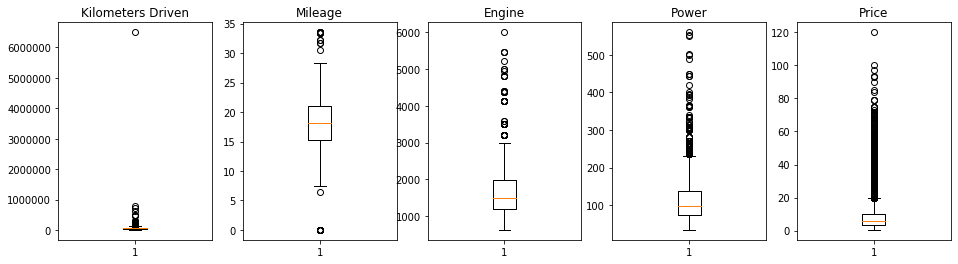

In [45]:
# Outlier를 확인해보자
# outlier: 이상치, 너무 크거나 너무 작은 값
fig, ax = plt.subplots(1, 5, figsize=(16,4))
ax[0].boxplot(list(clean_data.Kilometers_Driven))
ax[0].set_title("Kilometers Driven")

ax[1].boxplot(list(clean_data.Mileage))
ax[1].set_title("Mileage")

ax[2].boxplot(list(clean_data.Engine))
ax[2].set_title("Engine")

ax[3].boxplot(list(clean_data.Power))
ax[3].set_title("Power")

ax[4].boxplot(list(clean_data.Price))
ax[4].set_title("Price")

plt.show()

In [46]:
# 확인해보니 Kilometers Driven에 유독 큰 값이 있음
# 이를 제거해보자
idx = []
lt = list(clean_data["Kilometers_Driven"])
for i in range(len(lt)):
    if(lt[i] > 1000000):
        idx.append(i)
clean_data = clean_data.drop(idx)
clean_data = clean_data.reset_index(drop=True)

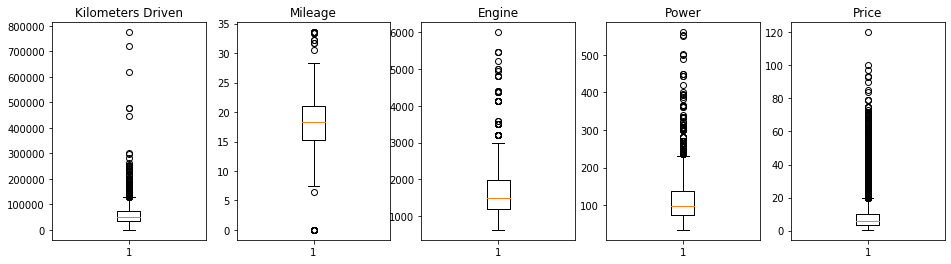

In [47]:
# Outlier를 다시 확인해보자
fig, ax = plt.subplots(1, 5, figsize=(16,4))
ax[0].boxplot(list(clean_data.Kilometers_Driven))
ax[0].set_title("Kilometers Driven")

ax[1].boxplot(list(clean_data.Mileage))
ax[1].set_title("Mileage")

ax[2].boxplot(list(clean_data.Engine))
ax[2].set_title("Engine")

ax[3].boxplot(list(clean_data.Power))
ax[3].set_title("Power")

ax[4].boxplot(list(clean_data.Price))
ax[4].set_title("Price")

plt.show()

In [48]:
# outlier가 없어졌다!
# 이제 데이터셋을 생서해보자 
# train data의 15퍼센트 정도를 test data에 사용
y = clean_data[['Price']].to_numpy()
clean_data = clean_data.drop(columns=['Price'])
x = clean_data.values
columns = clean_data.columns
scaler = preprocessing.MinMaxScaler()
tmp = scaler.fit_transform(x)
clean_data = pd.DataFrame(tmp)
clean_data.columns = columns

x = clean_data.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.85, random_state=1)

In [49]:
# 모델링! 다중 선형 회귀 사용
lr = LinearRegression(fit_intercept=True, normalize=True, copy_X=True)
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [50]:
# 결과 확인

In [51]:
# train data 정확도 측정
print('Train data Accuracy: ', format(lr.score(x_train, y_train)))

Train data Accuracy:  0.8011629967783105


In [52]:
y_predict = lr.predict(x_test)

In [53]:
# test data 정확도 측정
print('Test data Accuracy: ', format(lr.score(x_test, y_test)))
print('Test data Accuraty: ', format(r2_score(y_test, lr.predict(x_test))))

Test data Accuracy:  0.8107960180975305
Test data Accuraty:  0.8107960180975305


In [58]:
mean_absolute_error(y_test, y_predict)

2.9624031980144654

In [ ]:
# price의 오차 296000루피 한화 480만원